# Advanced lane finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [182]:
# Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Camera calibration


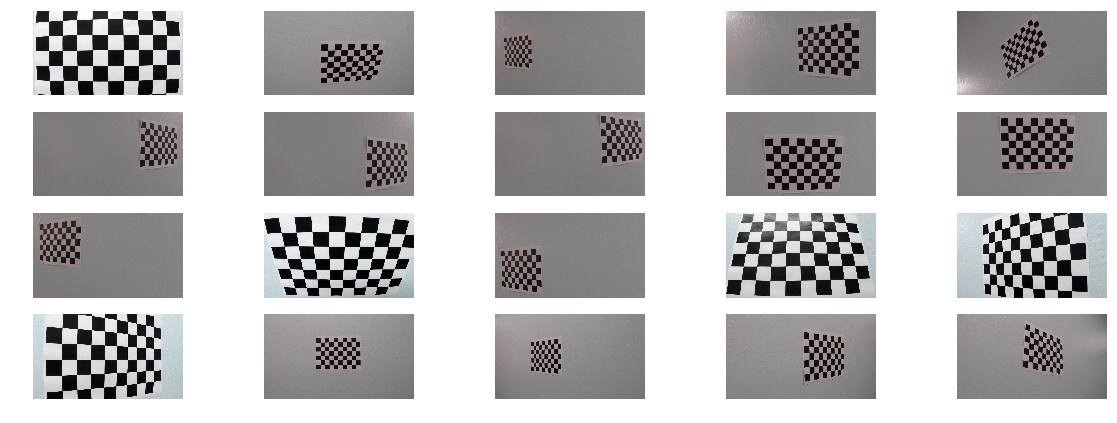

In [183]:
# Display the input images
import glob
images = glob.glob("camera_cal/calibration*.jpg")
columns = 5
rows = len(images) // columns + 1
plt.figure(figsize=(20, 9))
for i, file_name in enumerate(images):
    img = cv2.imread(file_name)      
    plt.subplot(rows, columns, i + 1)
    plt.axis("off")
    plt.imshow(img)

### Find the corners

The chessboard has 9*6 corners

Found 17 full chessboard out of 20 sample images


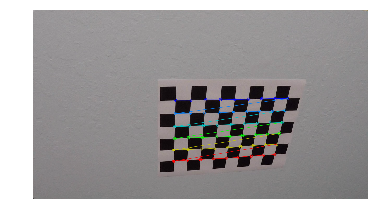

In [184]:
# Object and Image points for sample images
corner_dim = (9,6)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image space

sample_data = None;

# prepare object points
# like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

for i, file_name in enumerate(images):
    img = cv2.imread(file_name)    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, corner_dim, None)
    if ret == True:
        if sample_data is None:
            sample_data = (img, corners, ret) 
        objpoints.append(objp)
        imgpoints.append(corners)
                  
# Display a sample
if sample_data is not None:
    (img, corners, ret) = sample_data
    img_with_corners = img.copy()
    cv2.drawChessboardCorners(img_with_corners, corner_dim, corners, ret)
    plt.imshow(img_with_corners)
    plt.axis("off");  
    
# Some images does not display the full 9*6 chessboard    
print("Found {} full chessboard out of {} sample images".format(len(imgpoints), len(images)))    

## Calibrate the camera

* Use cv2 to calibrate the camera
* Undistort the image of a chessboard
* Undistort a test image

In [185]:
def undistort_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

True

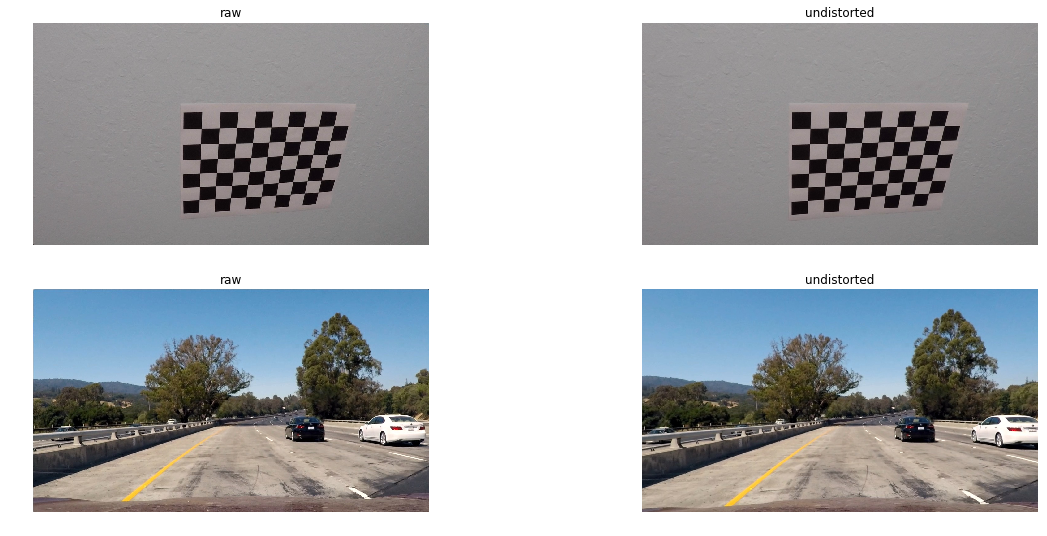

In [186]:
# Test calibration

(img, corners, ret) = sample_data

# Display the undistorted chessboard
plt.figure(figsize=(20, 9))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("raw")
plt.subplot(2, 2, 2)
plt.imshow(undistort_img(img))
plt.axis("off")
plt.title("undistorted")

# Display a test image undistorted
test_img = cv2.imread("test_images/test1.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.subplot(2, 2, 3)
plt.imshow(test_img)
plt.axis("off")
plt.title("raw")
plt.subplot(2, 2, 4)
plt.imshow(undistort_img(test_img))
plt.axis("off")
plt.title("undistorted")

# Save the test image undistorted
img = cv2.cvtColor(undistort_img(test_img), cv2.COLOR_RGB2BGR)
cv2.imwrite("output_images/test1_undistorted.jpg", img)

##  Create a threshold binary image


In [187]:
def create_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and extract the L & S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype("float")
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Use Sobel x on the L channel to find ~ vertical edges
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two thresholds
    combined = np.zeros_like(sxbinary)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1    
        
    return color_binary, combined

True

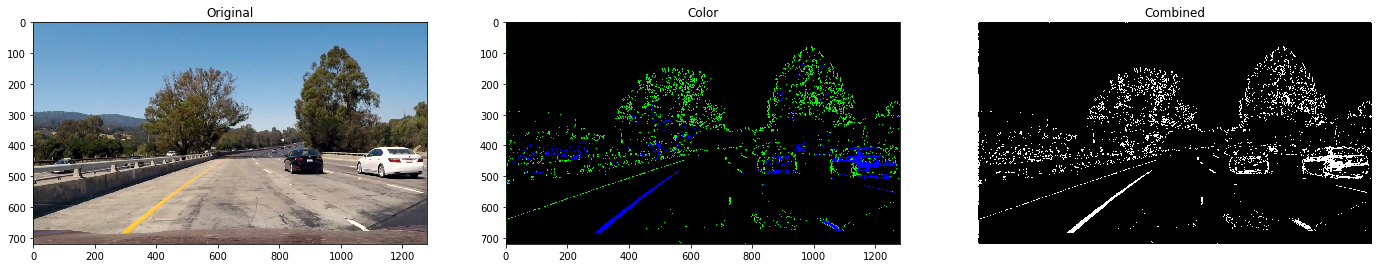

In [188]:
# Test threshold

img = cv2.imread("test_images/test1.jpg")
(dst, combined) = create_threshold(img, (190, 255), (30, 100))

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.axis("off")
ax1.set_title('Original')
ax2.imshow(dst)
plt.axis("off")
ax2.set_title('Color')
ax3.imshow(combined, cmap="gray")
plt.axis("off")
ax3.set_title('Combined')


binary = 255 * dst.astype("uint8")
binary = cv2.cvtColor(binary, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_images/test1_threshold.jpg", binary)

## Perspective transform

* define the src points on an image with straight lines
* compute the perspective matrice,
* warp the image

[[  235.   680.]
 [  562.   470.]
 [  728.   470.]
 [ 1055.   680.]]
[[  235.   680.]
 [  235.     0.]
 [ 1055.     0.]
 [ 1055.   680.]]


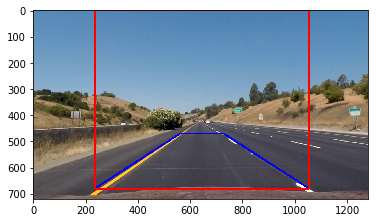

In [189]:
# Adjust the src and dst point on a test image

img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = undistort_img(img)

width = img.shape[1]
x_center = width // 2 + 5

y_top = 470
y_bottom = 680

# half width at top and bottom
w_top = 83
w_bottom = 410

src = np.float32([
    [x_center - w_bottom, y_bottom],
    [x_center - w_top, y_top],
    [x_center + w_top, y_top],
    [x_center + w_bottom, y_bottom],
])

dst = np.float32([
    [x_center - w_bottom, y_bottom],
    [x_center - w_bottom, 0],
    [x_center + w_bottom, 0],
    [x_center + w_bottom, y_bottom],    
])

src_pts = src.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(img, [src_pts], True, (0, 0, 255), thickness=5)

dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(img, [dst_pts], True, (255, 0, 0), thickness=5)

plt.imshow(img)
print(src)
print(dst)

In [190]:
# Use the area found in the previous section
src = [[  235.,   680.],
       [  562.,   470.],
       [  728.,   470.],
       [ 1055.,   680.],]

dst = [[  235.,   680.],
       [  235.,     0.],
       [ 1055.,     0.],
       [ 1055.,   680.],]

M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
M_inv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))

def warp_image(img):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

def inv_warp_image(img):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M_inv, img_size, flags=cv2.INTER_LINEAR)

True

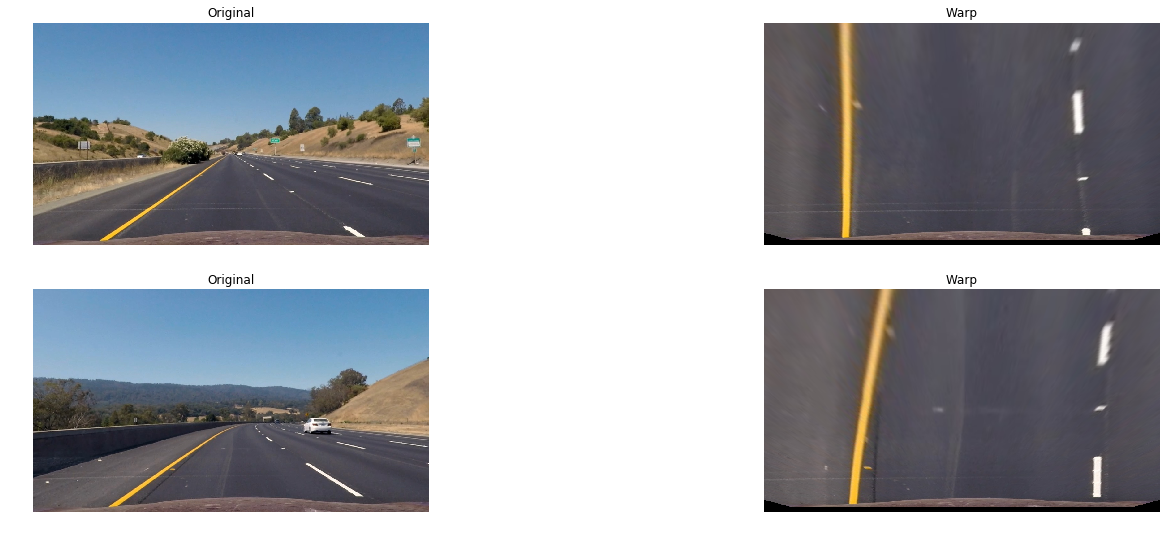

In [191]:
# Test image warp

img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = undistort_img(img)
warp = warp_image(img)

img_curve = cv2.imread("test_images/test3.jpg")
img_curve = cv2.cvtColor(img_curve, cv2.COLOR_RGB2BGR)
img_curve = undistort_img(img_curve)
warp_curve = warp_image(img_curve)

# Plot the result
plt.figure(figsize=(24, 9))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title('Original')
plt.subplot(2, 2, 2)
plt.imshow(warp)
plt.axis("off")
plt.title('Warp')
plt.subplot(2, 2, 3)
plt.imshow(img_curve)
plt.axis("off")
plt.title('Original')
plt.subplot(2, 2, 4)
plt.imshow(warp_curve)
plt.axis("off")
plt.title('Warp')

warp = cv2.cvtColor(warp, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_images/straight_lines1_warp.jpg", warp)

warp_curve = cv2.cvtColor(warp, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_images/test3.jpg", warp_curve)



## Find lane boundary

In [199]:
def compute_curvature(leftx, lefty, rightx, righty, ploty):    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)


In [200]:
# Use the sliding window algorithm describe in the course

def find_lane(binary_warped):        
    ## Step 1: find the starting point

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    ## Step 2: find the lanes in sliding windows

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = win_y_low + window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    return out_img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx

Curvature: left = 2618m, right = 1426m


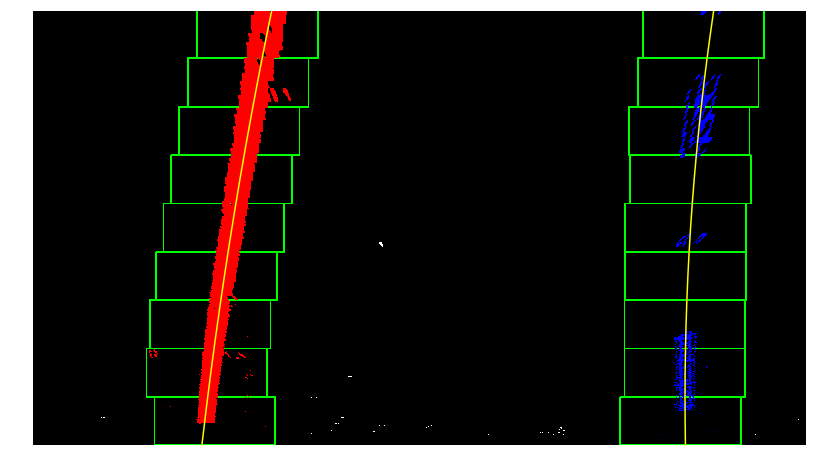

In [201]:
# Test lanes & curvature

img = cv2.imread("test_images/test3.jpg")
(color, binary) = create_threshold(img, (190, 255), (30, 100))
binary_warped = warp_image(binary)

(out_img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx) = find_lane(binary_warped)

plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

(left, right) = compute_curvature(leftx, lefty, rightx, righty, ploty)
print("Curvature: left = {:.0f}m, right = {:.0f}m".format(curvature[0], curvature[1]))

## Complete flow on a single image

In [227]:
def draw_frame(undistorted, binary_warped, left_rad, right_rad, left_fitx, right_fitx, ploty):
    # Image containing the lanes
    zero_channel = np.zeros_like(binary_warped).astype(np.uint8)
    output = np.dstack((zero_channel, zero_channel, zero_channel))
    
    # Draw the lanes
    pt_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pt_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((pt_left, pt_right))    
    cv2.fillPoly(output, np.int_([points]), (0, 255, 0))
    
    # Project the lanes back on the image space
    output = inv_warp_image(output)
    
    # Combine with the undistorted image and add curvatures
    output = cv2.addWeighted(undistorted, 1, output, 0.3, 0)    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Left: {:.0f}m - Right: {:.0f}m".format(left_rad, right_rad)
    cv2.putText(output, text, (20, 40), font, 1, (200, 200, 200), 3)
        
    return output    

In [228]:
def process_image(img):
    undistorted = undistort_img(img)
    (color, binary) = create_threshold(img, (190, 255), (30, 100))
    binary_warped = warp_image(binary)
    (out_img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx) = find_lane(binary_warped)
    (left_rad, right_rad) = compute_curvature(leftx, lefty, rightx, righty, ploty)    
    return draw_frame(undistorted, binary_warped, left_rad, right_rad, left_fitx, right_fitx, ploty)

True

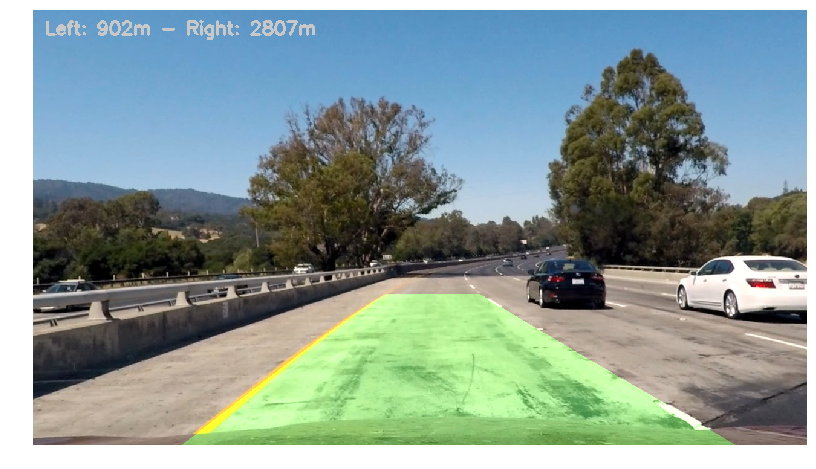

In [234]:
# Test the complete flow
img = cv2.imread("test_images/test1.jpg")

out = process_image(img)

plt.figure(figsize=(16,8))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
plt.axis("off")

cv2.imwrite("output_images/test1_full_pipeline.jpg", out)

## Process the video

In [236]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = "output_images/project_video.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image) 
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [14:51<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 15min 11s, sys: 58 s, total: 16min 9s
Wall time: 14min 51s


In [237]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))